In [1]:
!jt -t solarizedl -tf merriserif -tfs 14 -nf ptsans -nfs 14

This is a code after discussing with Xianyi from CMU, and after reading in-depth of work

- A convex polynomial force-motion model for planar sliding: identification and application
- A fast stochastic contact model for planar pushing and grasping: Theory and experimental validation

# Forward simulation
## Mathematical formulation
Two entities are involved in the process: a pusher and a slider. The forces involved are pusher-slider friction and slider-ground friction. The pusher-slider friction must lie inside the friction cone, while the slider-ground friction must like on the Limit Surface (LS).

Here are a list of variables considered for each object (here we assume the pushing point is located at $p$ relative to the slider's center frame.
### Pusher
- velocity at contact point $p$: $v_p^p$
- pusher-slider friction force: $f_p^p$

### Slider
- velocity at contact point $p$: $v_s^p$
- slider-ground friction force: $f_s^p$
- twist of body: $V_s$
- load of body: $F_s$
- limit surface: $H(F_s)$

### Relationship
The causal relationship is: $f_p^p=f_s^p$ (due to quasi-static assumption) -> $F_s$ -> $V_s$ -> $v_s^p$


### Mathematical Program
- $\hat{n}_p^Tv_p^p=\hat{n}_p^Tv_s^p$, $\hat{n}_p^Tv_p^p\geq0$ (non-breaking contact constraint)
- $f_p^p=f_s^p$ (quasi-static constraint)
- $f_p^p\in\textrm{cone}(f_l,f_r)$ (motion cone constraint)
- $F_s=J_p^Tf_s^p$ (force -> load)
- $V_s=s\Delta H(F_s)$ (limit surface constraint)
- $J_pV_s=v_s^p$ (twist -> point velocity)
- when $f_p^p\neq f_l, f_r$, $v_p^p=v_s^p$ (sticking constraint)

It can be derived that this program has one solution. It can be shown as follows.
Since $H(F_s)$ is a symmetric and convex surface, the twist is almost one-to-one given a load $F(s)$. Hence we can rewrite everthing based on symbols $f_s^p$ and $s$, with the motion cone constraint as the only constraint. This leaves us with 2 DOF for the program. Notice that the length of vector $f_s^p$ is fixed once the direction is fixed, since $H(F_s)$ is a symmetric convex surface. This leaves us with only one DOF to determine the direction of $f_s^p$ along the cone $(f_l, f_r)$.
Additionally, if the $f_s^p$ is not $f_l$ or $f_r$, then there is an additional constraint $f_p^p=f_s^p$ which reduces the DOF to 0. On the other hand, if $f_s^p$ is fixed, then the program is itself solved.

Hence we can solve this program by three steps:
- first, assume the contact is sticking and try to solve the problem
- if failed, then try to solve for $f_s^p=f_l,f_r$.

### case 1: sticking
the mathematical program is:
- $v_p^p=v_s^p$, $\hat{n}_p^Tv_p^p\geq0$ (sticking constraint)
- $f_p^p=f_s^p$ (quasi-static constraint)
- $f_p^p\in\textrm{cone}(f_l,f_r), f_p^p\neq f_l, f_r$ (motion cone constraint)
- $F_s=J_p^Tf_s^p$ (force -> load)
- $V_s=s\Delta H(F_s)$ (limit surface constraint)
- $J_pV_s=v_s^p$ (twist -> point velocity)

This reduces to finding $F_s$ that makes sure $V_s=s\Delta H(F_s)$.
Notice that the magnitude of $F_s$ is fixed given fixed friction coefficient and slider-ground pressure distribution.

In other words, this is to find $F_s$ such that
$$J_p\Delta H(J_p^Tf_s^p)=v_p^p$$


### case 2: sliding
$f_l$ means moving tangently in the same direction of $f_l$. $f_u$ means moving tangently in the same direction of $f_u$. Select the one that fits.

In [2]:
%matplotlib --list

# This is non-interactive: it shows static plots inline
# %matplotlib inline

# This is interactive: it shows dynamic plots in the notebook
%matplotlib notebook

# This is interactive: it shows dynamic plots in separate GUI windows
# %matplotlib tk

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [3]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

class LimitSurface:
    def __init__(self):
        pass
    def get_twist(self, F):
        """
        to find the velocity direction as the normal vector pointing outward
        """
        pass
    def get_load(self, V):
        """
        to find the friction force given the twist
        this finds the maximal point in the convex shape in the direction of V
        """
        pass
    def get_load_point_vel(self, p, v_p):
        """
        obtain the pushing force at point p, and the load F as a result of it
        twist could also be reported
        """        
        pass


## Limit surface modeling: through 2D grid to equip with model identification

In [4]:
class GridLimitSurface(LimitSurface):
    def __init__(self, friction_coeff, pressure_dist, width, height):
        """
        shape: 
        friction_coeff: NxM (width x height)
        pressure_dist: NxM
        """
        super().__init__()
        self.friction_coeff = friction_coeff
        self.pressure_dist = pressure_dist
        self.w = width
        self.h = height
        self.mat_x, self.mat_y = np.indices(self.friction_coeff.shape)
        self.mat_x = self.mat_x
        self.mat_y = self.mat_y
        self.hull = None
        self.com = np.array([self.mat_x.shape[0]/2, self.mat_x.shape[1]/2])
    def get_load(self, twist):
        """
        given a twist in the shape of: Bx3, [x,y,omega]
        find corresponding loads in the shape of: Bx3
        Notice that the load is in the reverse direction of the friction, and it is
        in the direction of velocity at each point
        """
        # get the normal direction of the twist
        twist = twist / np.linalg.norm(twist, axis=1).reshape((-1,1))
        twist = twist.reshape((len(twist),1,1,3))
        mat_x = self.mat_x.reshape((1,len(self.mat_x),len(self.mat_x[0]),1)) - self.com[0]
        mat_y = self.mat_y.reshape((1,len(self.mat_y),len(self.mat_y[0]),1)) - self.com[1]
        mat_x = mat_x * (self.w/self.mat_x.shape[0])  # scale to width and height
        mat_y = mat_y * (self.h/self.mat_y.shape[0])
        # obtain the velocity at each point
        v = np.zeros((len(twist),len(self.mat_x),len(self.mat_x[0]),3))
        v = v + twist
        v[...,0] = v[...,0] - v[...,2] * mat_y[...,0]
        v[...,1] = v[...,1] + v[...,2] * mat_x[...,0]
        v[...,2] = 0
        v = v / np.linalg.norm(v, axis=3, keepdims=True)
        # the angular velocity is omitted
        
        friction_coeff = self.friction_coeff.reshape((1,len(self.friction_coeff),
                                                      len(self.friction_coeff[0]),1))
        pressure_dist = self.pressure_dist.reshape((1,len(self.pressure_dist),
                                                      len(self.pressure_dist[0]),1))

        load = v * friction_coeff * pressure_dist  # BxNxMx3
        load[...,2] = mat_x[...,0]*load[...,1] - mat_y[...,0]*load[...,0]
        load = load.mean(axis=(1,2))  # result shape: Bx3
        return load
    
    def construct_limit_surface(self, n_samples=2500, ax=None):
        twists = np.random.normal(size=(n_samples,3))
        fs = self.get_load(twists)
        print('fs: ')
        print(fs)
        hull = ConvexHull(fs)

        # triple
        x = fs[:,0]
        y = fs[:,1]
        z = fs[:,2]
        # Triangulate parameter space to determine the triangles
        tri = mtri.Triangulation(x,y,triangles=hull.simplices)

        # Plot the surface.  The triangles in parameter space determine which x, y, z
        # points are connected by an edge.
        if ax is not None:
            ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
          
        self.hull = hull
        return hull
    def get_twist(self, F, plot_scale=0.1, ax=None):
        # https://stackoverflow.com/questions/30486312/intersection-of-nd-line-with-convex-hull-in-python
        if self.hull is None:
            print('constructing hull...')
            self.construct_limit_surface(ax=ax)
        # find the face that the force projects to
        eq=self.hull.equations.T
        V,b=eq[:-1].T,eq[-1]
        alpha=-b/np.dot(V,F)
        alpha[alpha<=0] = np.inf
        face_idx = np.argmin(alpha)
        proj_pt = alpha[face_idx]*F
        # TODO: plot this
        normal = self.hull.equations[face_idx,:-1]        
        normal = normal / np.linalg.norm(normal) * plot_scale
        if ax is not None:
            plt.plot([proj_pt[0],proj_pt[0]+normal[0]],
                     [proj_pt[1],proj_pt[1]+normal[1]],
                     [proj_pt[2],proj_pt[2]+normal[2]])
        print('projected point: ', proj_pt)
        print('normal: ', normal)
        return normal
    def get_load_point_vel(self, p, v_p, v_err=1e-3, f_err=5e-2):
        """
        assuming sticking contact,
        obtain the pushing force at point p, and the load F as a result of it
        to achieve the desired velocity v_p at point p
        """
        """
        # * step 1: find candidate loads such that
        # v_p = J_p Delta H(F)
        # * step 2: from the candidates, select ones that satisfy:
        # F = J^T f, i.e., F[2] = p[0]F[1] - p[1]F[0]
        # return the one with the least error. If no one is found, report failure
        """
        # * step 1: find candidate loads such that
        # v_p = J_p Delta H(F)
        eq=self.hull.equations.T
        V,b=eq[:-1].T,eq[-1]
        V = np.array(V)
        V = V / np.linalg.norm(V, axis=1).reshape((-1,1))  # Bx3
        # find Jp V = v
        v = np.zeros((len(V),2))
        v[:,0] = V[:,0] - V[:,2]*p[1]
        v[:,1] = V[:,1] + V[:,2]*p[0]
        v = v / np.linalg.norm(v, axis=1).reshape((-1,1))        
        # cosine similarity is the largest
        sim = v.dot(v_p)/np.linalg.norm(v_p)
        # check the largest ones
        print('sorted similarity scores: ')
        print(np.sort(sim)[::-1])
        cand_mask = sim > (1-v_err)
        cand_faces = self.hull.simplices[cand_mask, :]  # B x 3, indices of points
        cand_loads = self.hull.points[cand_faces, :]  # select the indices of points
                                                      # result shape: Bx3x3
        cand_loads = np.mean(cand_loads, axis=1)  # result shape: Bx3
        
        # check if any points can satisfy the error
        error = np.abs(p[0]*self.hull.points[:,1] - p[1]*self.hull.points[:,0] - 
                       self.hull.points[:,2])
        error = error / np.linalg.norm(self.hull.points, axis=1)
        print('sorted errors for all points: ')
        print(np.sort(error))
        
        # * step 2: from the candidates, select ones that satisfy:
        # F = J^T f, i.e., F[2] = p[0]F[1] - p[1]F[0]
        # error function we use here: (LHS-RHS)/norm(F)
        
        error = np.abs(p[0]*cand_loads[:,1] - p[1]*cand_loads[:,0] - cand_loads[:,2])
        error = error / np.linalg.norm(cand_loads, axis=1)
        print('sorted errors: ')
        print(np.sort(error))
        cand = error < f_err
        # check whether it is solved: i.e. cand has at least one
        if np.sum(cand) == 0:
            return None
        return cand_loads[np.argmin(error)]
    
#     def get_ls_f(self, vel):
#         # find the force that corresponds to the normal direction vel
#         # the one with the max inner product
#         if self.hull is None:
#             print('constructing hull...')
#             self.construct_ls_db(ax=ax)

#         vel = vel / np.linalg.norm(vel)
#         idx = np.argmax(self.hull.points.dot(vel))
#         return self.hull.points[idx]
    
    

In [5]:
friction_coeff = np.ones((5,5))
pressure_dist = np.ones((5,5))
width = 0.1
height = 0.1

grid_ls = GridLimitSurface(friction_coeff, pressure_dist, width, height)



<IPython.core.display.Javascript object>


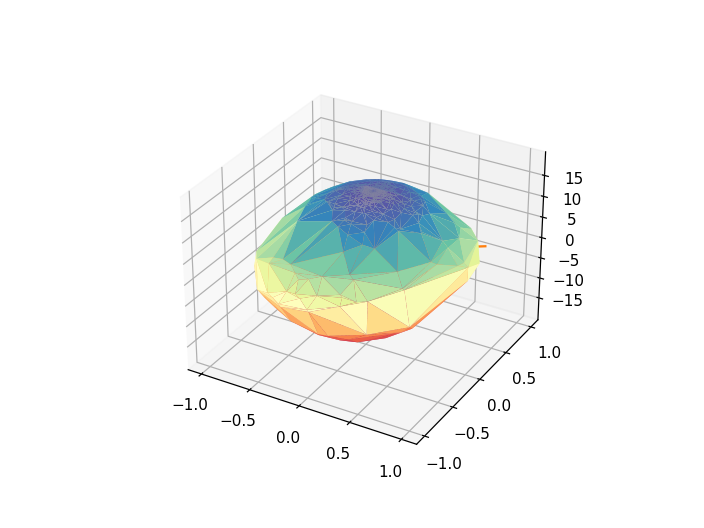

constructing hull...
fs: 
[[  0.1674407   -0.2087384   19.72487818]
 [ -0.09053565   0.24118393 -19.56181024]
 [  0.18316941  -0.13902508  19.72175404]
 ...
 [  0.23131037  -0.25704481  19.58217765]
 [  0.13929484  -0.17173295  19.72262699]
 [  0.12603152  -0.56951088  17.43919191]]
projected point:  [0.69918702 0.69918702 0.        ]
normal:  [8.28691918e-02 5.59704905e-02 3.54277364e-05]


array([8.28691918e-02, 5.59704905e-02, 3.54277364e-05])

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
grid_ls.get_twist(F=np.array([0.1,0.1,0]), ax=ax)


In [43]:
import matplotlib.patches as matpat

def visualize(p, v_pusher, fl, fu, H, F, f):
    alpha = H.friction_coeff*H.pressure_dist
    alpha = alpha / alpha.max()    
    SCALE = 10
    xmin = -H.w/2*1.5
    xmax = H.w/2 * 1.5
    ymin = -H.h/2*1.5
    ymax = H.h/2*1.5
    fig, ax = plt.subplots()
    plt.axis([xmin, xmax, ymin, ymax])        
    # draw the grid
    dx = H.w / H.mat_x.shape[0]
    dy = H.h / H.mat_x.shape[1]
    for i in range(H.mat_x.shape[0]):
        for j in range(H.mat_x.shape[1]):
            x = -H.w/2 + i*dx
            y = -H.h/2 + j*dy
            slider_ij = plt.Rectangle((x,y), dx, dy, color='gray', alpha=alpha[i,j])
            # we approxiate each rectangular grid by a circle to be symmetric
            
            # TODO: adjust color based on value
            ax.add_patch(slider_ij)

    # fl, fu
    fl = dx*2*fl/np.linalg.norm(fl)
    fu = dx*2*fu/np.linalg.norm(fu)
    f = dx*2*f/np.linalg.norm(f)
    print('fl: ', fl)
    print('fu: ', fu)
    print('f: ', f)
    print('p: ', p)

    fl_arrow = plt.arrow(p[0],p[1], fl[0],fl[1], width=dx/10,color='black')
    fu_arrow = plt.arrow(p[0],p[1], fu[0],fu[1], width=dx/10,color='black')
    f_arrow = plt.arrow(p[0],p[1], f[0],f[1], width=dx/10,color='blue')
    ax.add_patch(fl_arrow)
    ax.add_patch(fu_arrow)
    ax.add_patch(f_arrow)

    # velocities
    V = H.get_twist(F)
    # get slider velocity
    v = np.zeros((2))
    v[0] = V[0] - p[1] * V[2]
    v[1] = V[1] + p[0] * V[2]
    v = v / np.linalg.norm(v) *(dx*2)
    v_arrow = plt.arrow(p[0],p[1], v[0], v[1], width=dx/10,color='red')
    ax.add_patch(v_arrow)
    vp = v_pusher / np.linalg.norm(v_pusher) *(dx*2)

    vp_arrow = plt.arrow(p[0],p[1], vp[0], vp[1], width=dx/10,color='green')
    ax.add_patch(vp_arrow)

    fig.show()        

def point_pusher_model(p, v_pusher, fl, fu, H: LimitSurface, vis=None):
    """
    given the pushing point p, the velocity of the pusher v_pusher, and the limit surface model H.
    determine the velocity of the slider. (other intermediate values such as frictions too)
    """
    
    # * check if it's sticking mode: find F such that the equation holds
    # check the normals to the convex hull faces, and find the one closest to v_pusher
    F = H.get_load_point_vel(p, v_pusher, v_err=1e-3, f_err=1e-1)
    

    print('load: ', F)
    if F is None:
        print('unable to find sticking mode.')
    else:
        # check the force to remain in the cone
        f = np.array(F[:2])
        theta_fl = np.arctan2(fl[1], fl[0])
        theta_fu = np.arctan2(fu[1], fu[0])
        if theta_fu < theta_fl:
            theta_fu += np.pi*2
        theta_f = np.arctan2(f[1], f[0])
        if theta_f < theta_fl:
            theta_f += np.pi*2
        if theta_fl < theta_f and theta_f < theta_fu:
            print('within cone')
            if vis:
                visualize(p, v_pusher, fl, fu, H, F, f)
            return F
    
    # * otherwise it's in the sliding mode
    # f = fl or fu
    F = np.array([fl[0], fl[1], p[0]*fl[1]-p[1]*fl[0]])
    Fl = np.array(F)
    V = H.get_twist(F)
    # verify the difference
    v = np.zeros((2))
    v[0] = V[0] - p[1]*V[2]
    v[1] = V[1] + p[0]*V[2]
    # check if it's fit
    normal = (fl+fu)/2
    flt = fl - fl.dot(normal)*normal
    vt = v - v.dot(normal)*normal  # get the tangent velocity
    if vt.dot(flt) >= 0:
        visualize(p, v_pusher, fl, fu, H, F, fl)
        print('picking fl')
        return Fl
    else:
        F = np.array([fu[0], fu[1], p[0]*fu[1]-p[1]*fu[0]])
        Fu = np.array(F)
        visualize(p, v_pusher, fl, fu, H, F, fu)
        print("picking fu")
        return Fu
    # F = np.array([fu[0], fu[1], p[0]*fu[1]-p[1]*fu[0]])
    # Fu = np.array(F)
    # V = H.get_twist(F)
    # # verify the difference
    # v = np.zeros((2))
    # v[0] = V[0] - p[1]*V[2]
    # v[1] = V[1] + p[0]*V[2]
    # normal = (fl+fu)/2
    # fut = fu - fu.dot(normal)*normal
    # vt = v - v.dot(normal)*normal  # get the tangent velocity
    # if vt.dot(fut) >= 0:
    #     visualize(p, v_pusher, fl, fu, H, F, fu)
    #     print('picking fu')
    #     return Fu
    

fs: 
[[  0.20915808  -0.15400133  19.71842432]
 [  0.21007388  -0.15383209  19.71733147]
 [ -0.13757059   0.21073566 -19.70156608]
 ...
 [ -0.18944478   0.19373634 -19.73464176]
 [ -0.05204726  -0.57447514  16.67474631]
 [ -0.15317401   0.25240889 -19.64347906]]


<IPython.core.display.Javascript object>


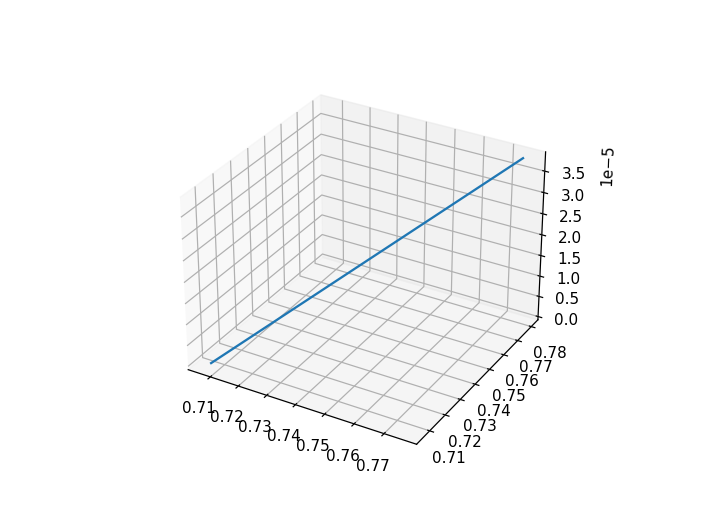

projected point:  [0.70701785 0.70701785 0.        ]
normal:  [6.86971626e-02 7.26684137e-02 3.86356383e-05]


array([6.86971626e-02, 7.26684137e-02, 3.86356383e-05])

In [44]:
friction_coeff = np.zeros((5,5))
pressure_dist = np.zeros((5,5))

# construct one in the shape of circle
# x_ind, y_ind = np.indices(friction_coeff.shape)
# mask = (np.sqrt((x_ind-5)**2+(y_ind-5)**2) <= 5)
# friction_coeff[mask] = 1
# pressure_dist[mask] = 1
friction_coeff += 1
pressure_dist += 1


width = 0.1
height = 0.1

grid_ls = GridLimitSurface(friction_coeff, pressure_dist, width, height)
grid_ls.construct_limit_surface(n_samples=75000)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
grid_ls.get_twist(F=np.array([0.1,0.1,0]), ax=ax)

p:  [0.01919877 0.05      ]
norm:  [ 0. -1.]
v_pusher dot norm:  -0.5537707501833581
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors for all points: 
[0.00302657 0.03252025 0.03324    ... 1.00143083 1.00143248 1.0014326 ]
sorted errors: 
[0.0110415  0.025714   0.1170361  ... 1.00108798 1.00108868 1.00109321]
load:  [-0.80164862 -0.59059078  0.01774794]
theta_fl:  -3.141592653589793
theta_fu:  -6.123233995736766e-17
theta_f:  -2.506644895944864
within cone


<IPython.core.display.Javascript object>


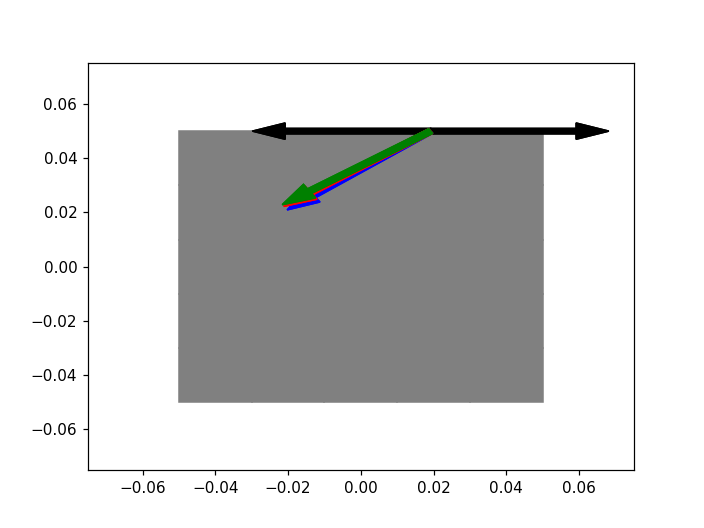

fl:  [-4.0000000e-02 -2.4492936e-18]
fu:  [ 4.0000000e-02 -2.4492936e-18]
f:  [-0.03220411 -0.02372542]
p:  [0.01919877 0.05      ]
projected point:  [-0.80164862 -0.59059078  0.01774794]
normal:  [-0.08238631 -0.05667688  0.00047723]


array([-0.80164862, -0.59059078,  0.01774794])

In [51]:
p = np.array([-width/2, height/4])
# randomly sample a point on the surface
p = np.random.normal(size=(2))
p = p / np.linalg.norm(p)
dif = np.array([width/2, height/2]) / np.abs(p)
p = np.min(dif) * p
if p[0] == -width/2:
    norm = np.array([1.0,0])
elif p[0] == width/2:
    norm = np.array([-1.0,0])
if p[1] == -height/2:
    norm = np.array([0, 1.0])
elif p[1] == height/2:
    norm = np.array([0,-1.0])
print('p: ', p)
v_pusher = np.random.normal(size=(2))
v_pusher = v_pusher / np.linalg.norm(v_pusher)
print('norm: ', norm)
print('v_pusher dot norm: ', np.dot(v_pusher, norm))
if np.dot(v_pusher, norm) < 0:
    v_pusher = -v_pusher
# v_pusher = np.array([0.1, 0.05])
# TODO: find a way to compute fl and fu
def get_rotation_mat(ang):
    # given ang in radians, get the rotation matrix
    return np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])
fl = get_rotation_mat(-np.pi/2).dot(norm)
fu = get_rotation_mat(np.pi/2).dot(norm)
point_pusher_model(p, v_pusher, fl, fu, grid_ls, vis=True)